In [203]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [204]:
name_molecule = r'$H_{2}O$'

#### Load CRD results

In [167]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_h2O_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_H2O_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [181]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_H2O_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [141]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls75pro_H2O/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [142]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_H2O/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)



# Total cooling rates

In [206]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
    map(list, zip(*infos_wavenumber))
    
    dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                      for pnl in pnls_wavenumber]
    
    names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
    map(list, zip(*infos_spectralband))
    
    dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                       for pnl in pnls_spectralband]
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total cooling rate. {}'.format(name_molecule),
                              cooling_rate = True,
                         xlim_linear = xlim_linear)
    
    display.display(plt.gcf()); plt.close()
    

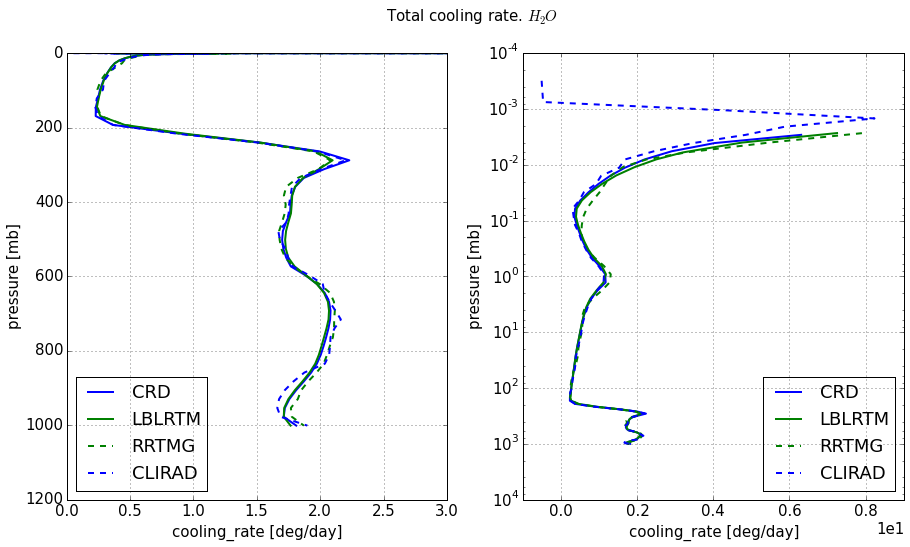

In [215]:
xlim_linear = (0, 3)

plot_total_cooling_rates(infos_wavenumber = [('CRD', 'b', '-', pnl_crd),\
                                            ('LBLRTM', 'g', '-', pnl_lblrtm),\
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

In [220]:
xlim_linear = (- 0.1, 1.5)

# In RRTMG's wavenumber bands

In [210]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    
    lbl_pnls_by_rrtmg_bands = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
                              for pnl_lbl in pnls_lbl]
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in lbl_pnls_by_rrtmg_bands]
        dfs.append(pnl_rrtmg[item].loc[atm_levels, :])
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      
        dfs = [pnl[item] for pnl in lbl_pnls_by_rrtmg_bands]
        dfs.append(pnl_rrtmg[item])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = True,
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -36.618217   0.000000 -36.618217      0.000000
30   299.800000 -38.842137  22.076937 -16.765200      1.442737
0   1013.000000 -54.573788  54.550693  -0.023095      0.008350

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -36.723339   0.000000 -36.723339      0.000000
30   299.8000 -38.985445  22.030611 -16.954833      1.334082
0   1013.0000 -54.581667  54.656241   0.074573      0.030404

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -36.3061     0.0000  -36.3061      -0.00000
30   299.70000 -38.7258    22.3568  -16.3690       1.36489
0   1013.00000 -54.5825    54.5778   -0.0047       0.00201

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
7

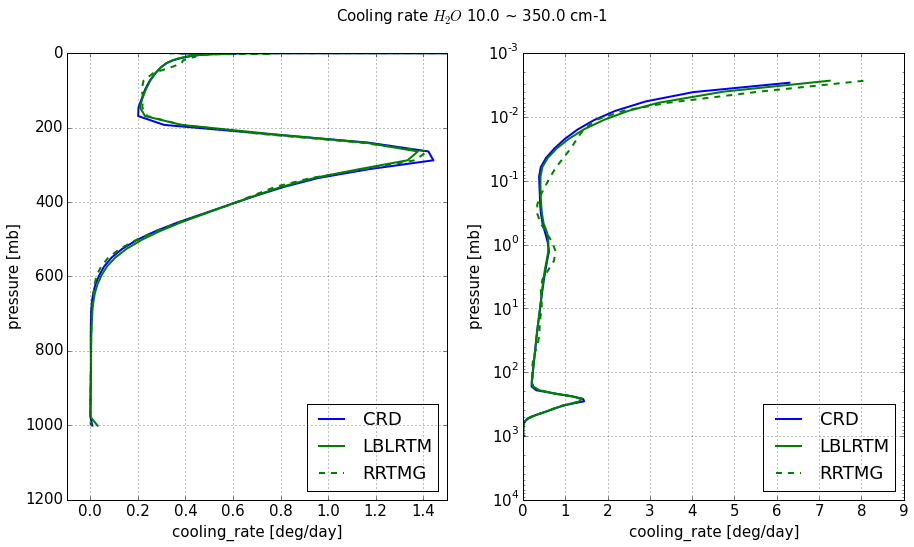

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -44.422999   0.000000 -44.422999      0.000000
30   299.800000 -45.270518   5.428052 -39.842466      0.522785
0   1013.000000 -60.916638  60.564791  -0.351847      0.065126

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -44.312334   0.000000 -44.312334      0.000000
30   299.8000 -45.185905   5.581554 -39.604351      0.506829
0   1013.0000 -60.917465  60.568471  -0.348993      0.074194

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -44.3208     0.0000  -44.3208      -0.00000
30   299.70000 -45.1535     5.2688  -39.8847       0.46769
0   1013.00000 -60.9174    60.7515   -0.1659       0.05173

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.110665   0.000000 -0.110665      0.00000

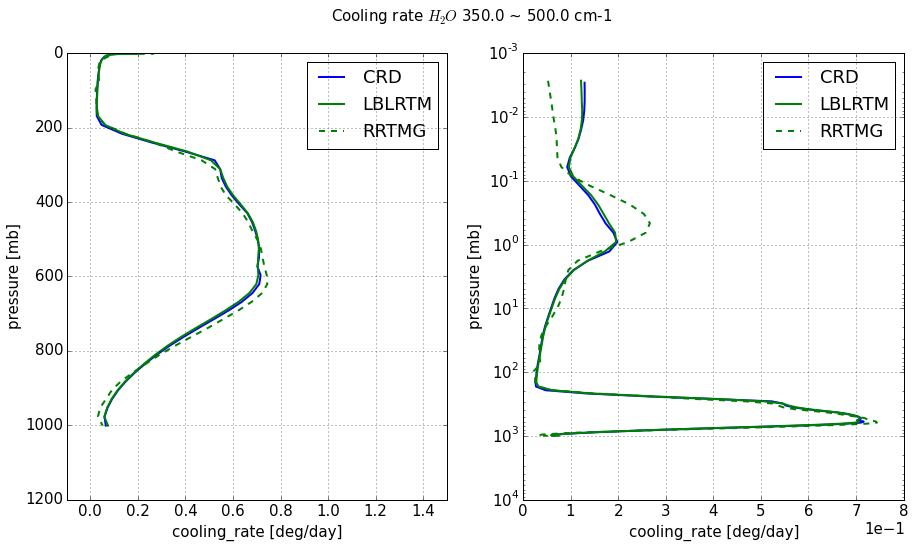

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -47.204841   0.000000 -47.204841      0.000000
30   299.800000 -47.486463   1.183130 -46.303334      0.124701
0   1013.000000 -58.652387  53.147737  -5.504650      0.378407

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -47.012150   0.000000 -47.012150      0.000000
30   299.8000 -47.309167   1.253733 -46.055434      0.126809
0   1013.0000 -58.646623  53.244945  -5.401678      0.367988

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -47.0755     0.0000  -47.0755      -0.00000
30   299.70000 -47.3985     1.1975  -46.2010       0.11909
0   1013.00000 -58.6463    54.0152   -4.6311       0.40161

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.192691   0.000000 -0.192691      0.00000

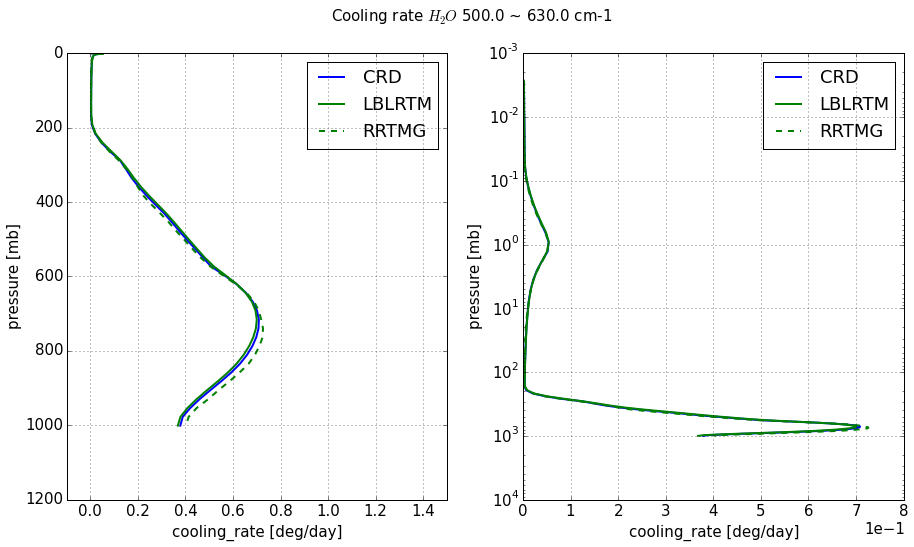

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -27.069898   0.000000 -27.069898      0.000000
30   299.800000 -27.127383   0.173199 -26.954184      0.019684
0   1013.000000 -30.901144  20.322693 -10.578451      0.298899

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -27.048460   0.000000 -27.048460      0.000000
30   299.8000 -27.107277   0.174463 -26.932814      0.019042
0   1013.0000 -30.895458  20.365852 -10.529606      0.291866

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -27.1021     0.0000  -27.1021      -0.00000
30   299.70000 -27.1641     0.1609  -27.0032       0.01793
0   1013.00000 -30.8951    20.5885  -10.3066       0.31701

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.021438   0.000000 -0.021438      0.00000

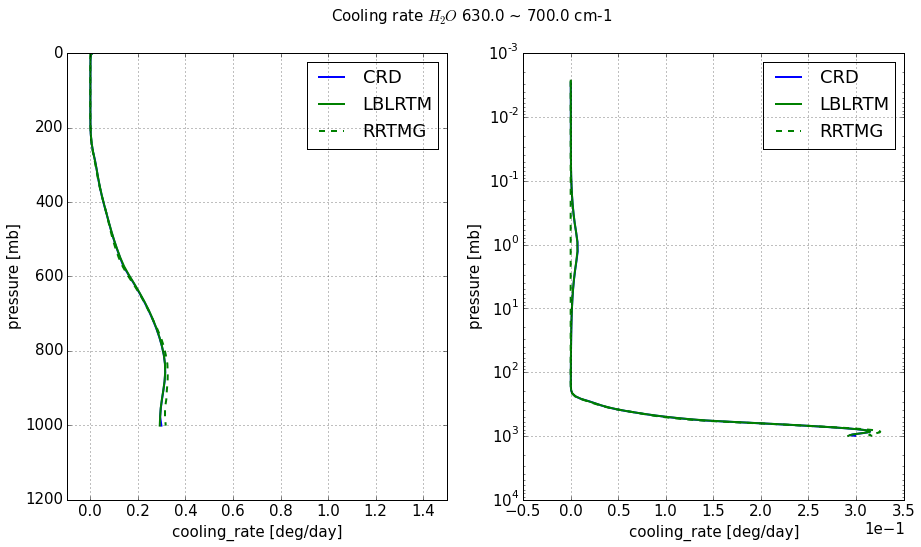

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -45.981097   0.000000 -45.981097      0.000000
30   299.800000 -46.010205   0.058138 -45.952067      0.005716
0   1013.000000 -48.899846  17.046923 -31.852922      0.372074

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -45.956634   0.000000 -45.956634      0.000000
30   299.8000 -45.986205   0.057718 -45.928487      0.005441
0   1013.0000 -48.886744  17.071499 -31.815245      0.361913

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -46.0020     0.0000  -46.0020      -0.00000
30   299.70000 -46.0326     0.0487  -45.9839       0.00448
0   1013.00000 -48.8867    17.0901  -31.7966       0.38616

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.024463   0.000000 -0.024463      0.00000

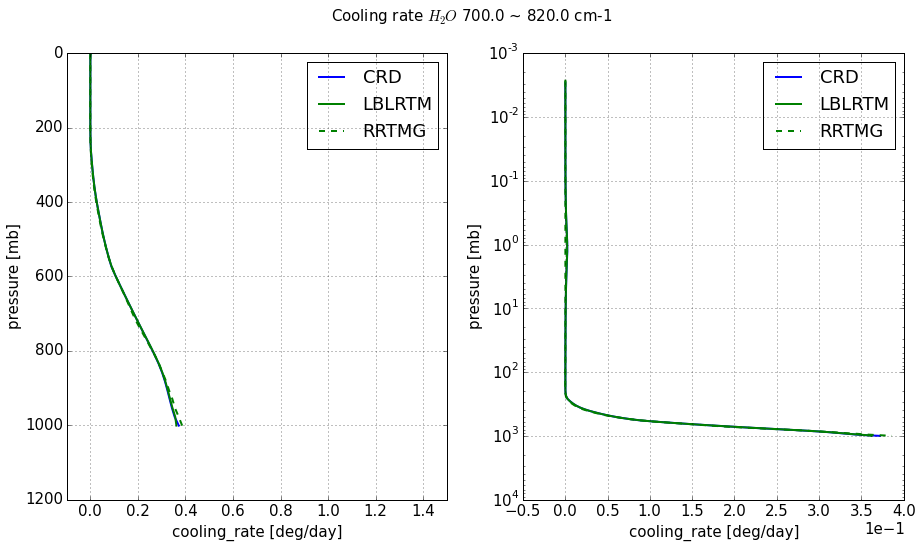

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -53.054398   0.000000 -53.054398      0.000000
30   299.800000 -53.059742   0.004696 -53.055046     -0.000011
0   1013.000000 -53.981634   6.000207 -47.981427      0.178273

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -53.022931   0.000000 -53.022931      0.000000
30   299.8000 -53.028271   0.004477 -53.023794     -0.000042
0   1013.0000 -53.960338   5.960443 -47.999895      0.168585

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.0264     0.0000  -53.0264      -0.00000
30   299.70000 -53.0324     0.0038  -53.0286      -0.00025
0   1013.00000 -53.9607     6.1714  -47.7893       0.18999

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.031467   0.000000 -0.031467      0.00000

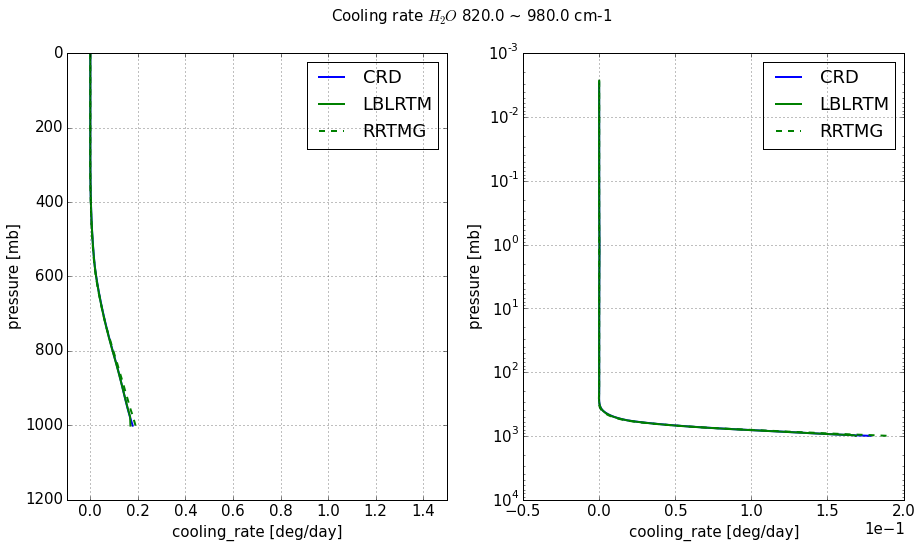

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -26.286758   0.000000 -26.286758      0.000000
30   299.800000 -26.288478   0.001112 -26.287366     -0.000083
0   1013.000000 -26.654056   2.197288 -24.456768      0.071793

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -26.267006   0.000000 -26.267006      0.000000
30   299.8000 -26.268713   0.001066 -26.267647     -0.000084
0   1013.0000 -26.640246   2.184222 -24.456024      0.067453

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -26.2661     0.0000  -26.2661      -0.00000
30   299.70000 -26.2683     0.0010  -26.2673      -0.00018
0   1013.00000 -26.6402     2.2795  -24.3607       0.07521

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.019753   0.000000 -0.019753  0.000000e+

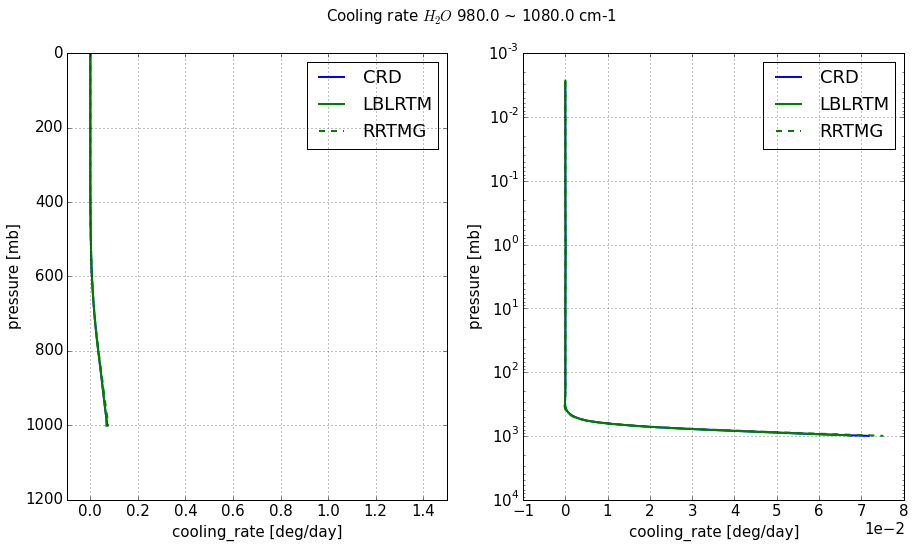

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -20.552467   0.000000 -20.552467      0.000000
30   299.800000 -20.559894   0.007166 -20.552729      0.000092
0   1013.000000 -21.535940   4.360290 -17.175650      0.114865

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -20.539627   0.000000 -20.539627      0.000000
30   299.8000 -20.547063   0.006978 -20.540085      0.000067
0   1013.0000 -21.522739   4.351903 -17.170835      0.111439

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.5192     0.0000  -20.5192      -0.00000
30   299.70000 -20.5287     0.0066  -20.5221      -0.00014
0   1013.00000 -21.5225     4.5509  -16.9716       0.12243

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.012840   0.000000 -0.012840      0.000

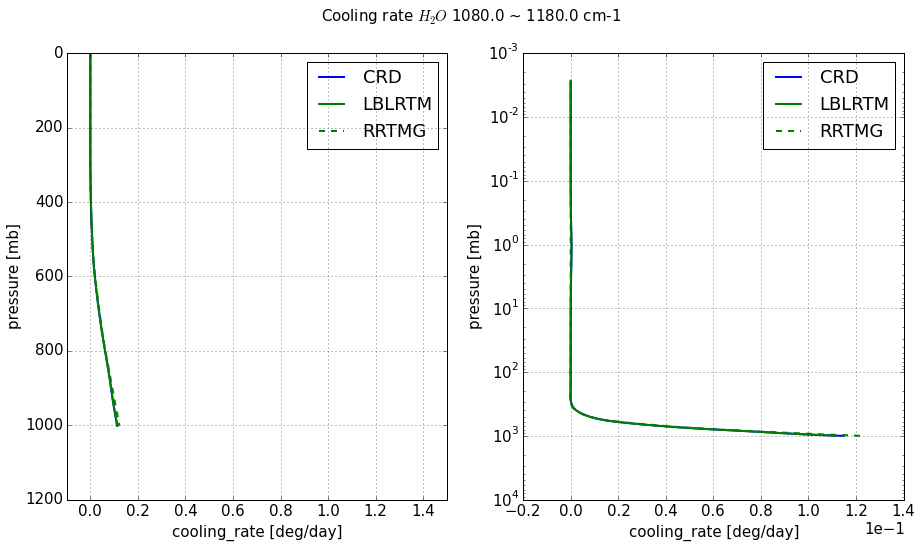

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -22.364859   0.000000 -22.364859      0.000000
30   299.800000 -22.516322   0.240063 -22.276259      0.013872
0   1013.000000 -31.323236  22.084979  -9.238257      0.247089

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.383453   0.000000 -22.383453      0.000000
30   299.8000 -22.535776   0.239734 -22.296042      0.013208
0   1013.0000 -31.299603  22.000981  -9.298622      0.247393

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -22.0664     0.0000  -22.0664      -0.00000
30   299.70000 -22.3024     0.3088  -21.9936       0.01648
0   1013.00000 -31.2998    22.2084   -9.0914       0.25038

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.018594   0.000000  0.018594      0.000

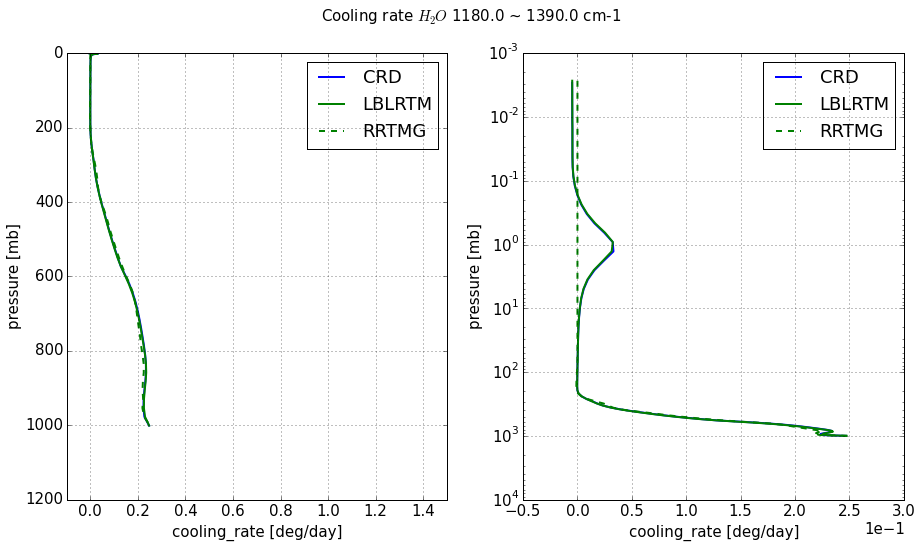

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.529233   0.000000 -2.529233      0.000000
30   299.800000 -2.762602   0.447570 -2.315032      0.027789
0   1013.000000 -8.906562   8.890356 -0.016206      0.005849

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.543163   0.000000 -2.543163      0.000000
30   299.8000 -2.778233   0.450082 -2.328151      0.026121
0   1013.0000 -8.898490   8.879336 -0.019154      0.004226

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.4808     0.0000   -2.4808      -0.00000
30   299.70000  -2.7200     0.4662   -2.2538       0.02661
0   1013.00000  -8.8986     8.8866   -0.0120       0.00512

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.013930   0.000000  0.013930      0.000000
30  0.000000

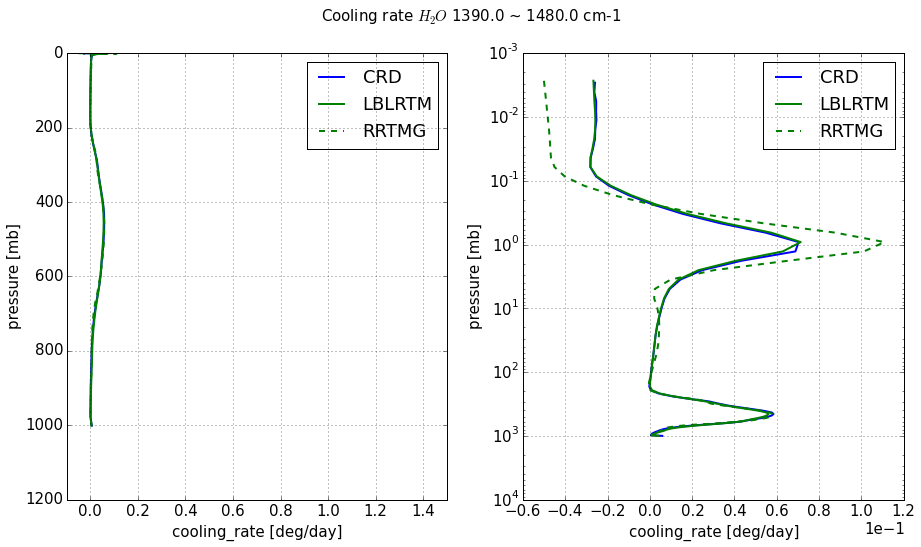

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

CRD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -3.353829   0.000000 -3.353829      0.000000
30   299.800000  -3.996974   1.237523 -2.759451      0.071399
0   1013.000000 -17.902258  17.865359 -0.036899      0.013083

LBLRTM
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -3.362121   0.000000 -3.362121      0.000000
30   299.8000  -4.019593   1.248877 -2.770716      0.065686
0   1013.0000 -17.882889  17.851415 -0.031474      0.004635

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -3.2226     0.0000   -3.2226      -0.00000
30   299.70000  -3.8991     1.2651   -2.6340       0.06488
0   1013.00000 -17.8828    17.8685   -0.0143       0.00607

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.008292   0.000000  0.008292      0.000000
30  

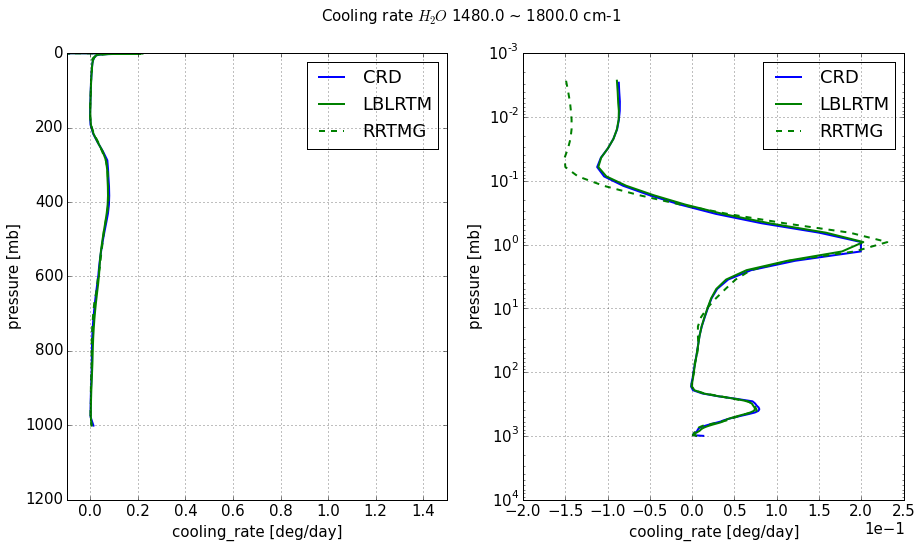

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.816395   0.000000 -2.816395      0.000000
30   299.800000 -2.863743   0.054956 -2.808787      0.001090
0   1013.000000 -5.965987   5.251580 -0.714406      0.039084

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.786328   0.000000 -2.786328      0.000000
30   299.8000 -2.834016   0.055757 -2.778259      0.001067
0   1013.0000 -5.957771   5.179354 -0.778417      0.019002

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.7629     0.0000   -2.7629      -0.00000
30   299.70000  -2.8171     0.0630   -2.7541       0.00084
0   1013.00000  -5.9578     5.2503   -0.7075       0.04283

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.030067   0.000000 -0.030067      0.000000
30  0.000000

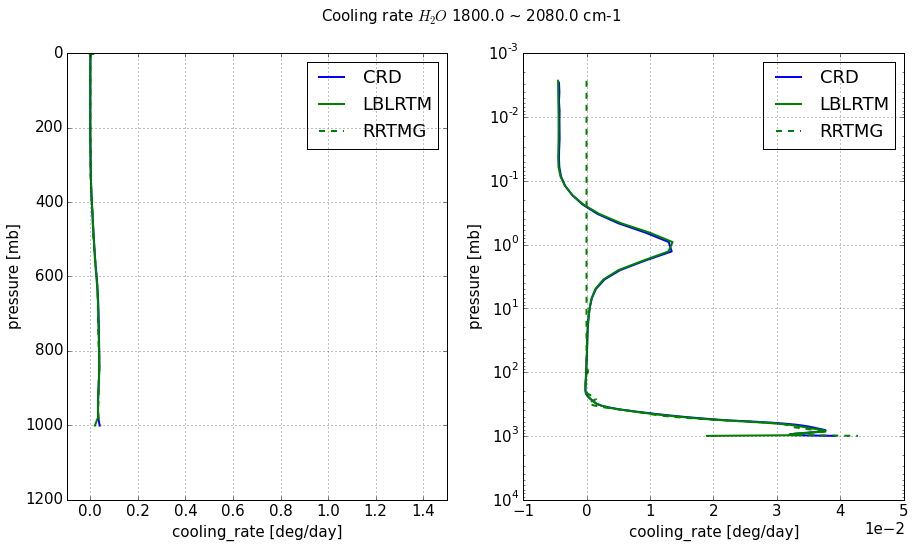

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -1.477430   0.000000 -1.477430      0.000000
30   299.800000 -1.478102   0.000236 -1.477865     -0.000072
0   1013.000000 -1.641655   0.446475 -1.195180      0.013461

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.470747   0.000000 -1.470747      0.000000
30   299.8000 -1.471435   0.000242 -1.471193     -0.000070
0   1013.0000 -1.639014   0.455507 -1.183507      0.013219

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.4164     0.0000   -1.4164      -0.00000
30   299.70000  -1.4180     0.0002   -1.4178      -0.00021
0   1013.00000  -1.6390     0.5408   -1.0982       0.01455

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.006683   0.000000 -0.006683      0.000000
30  0.000000

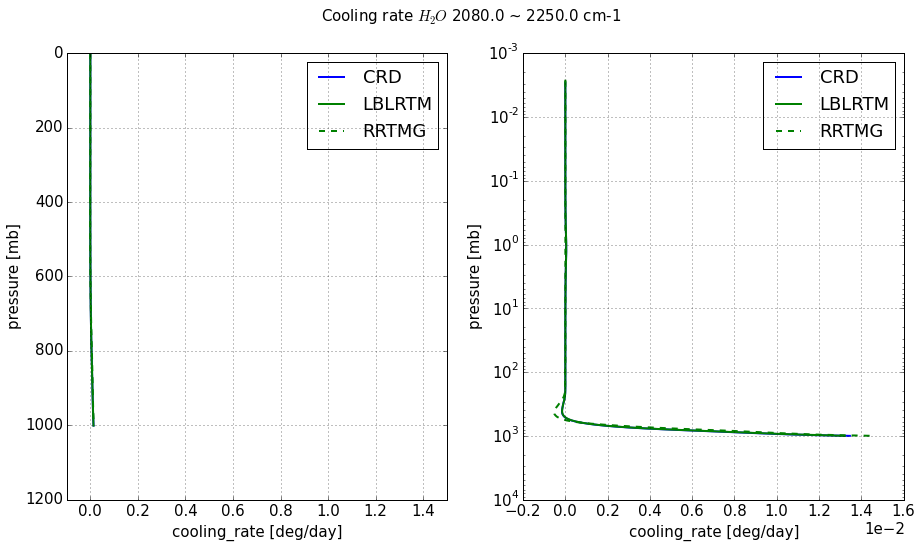

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.718921   0.000000 -0.718921      0.000000
30   299.800000 -0.718951   0.000003 -0.718948     -0.000005
0   1013.000000 -0.732844   0.045352 -0.687492      0.001860

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.717038   0.000000 -0.717038      0.000000
30   299.8000 -0.717068   0.000003 -0.717065     -0.000005
0   1013.0000 -0.731556   0.046003 -0.685553      0.001722

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.7315          0   -0.7315            -0
30   299.70000  -0.7315          0   -0.7315            -0
0   1013.00000  -0.7316          0   -0.7316            -0

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70  0.000017 -0.001883  0.000000e+00 -0.001883  0.000000e+00
30  0.

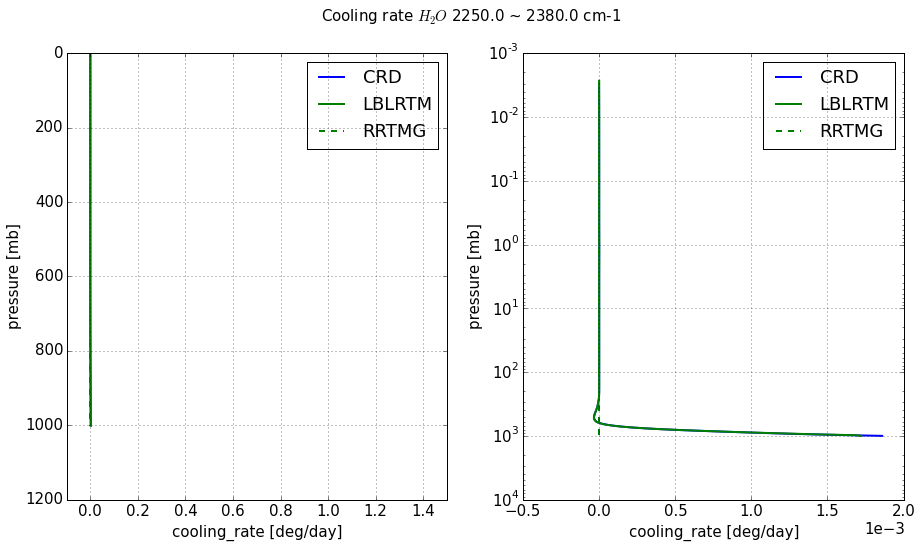

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -0.663910  0.000000e+00 -0.663910      0.000000
30   299.800000 -0.663925  7.815591e-07 -0.663924     -0.000002
0   1013.000000 -0.667119  8.808146e-03 -0.658311      0.000385

LBLRTM
     pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.0024 -0.662192  0.000000e+00 -0.662192      0.000000
30   299.8000 -0.662207  7.552275e-07 -0.662206     -0.000002
0   1013.0000 -0.665840  8.842813e-03 -0.656997      0.000234

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.5487     0.0000   -0.5487      -0.00000
30   299.70000  -0.5702     0.0007   -0.5695      -0.00110
0   1013.00000  -0.6658     0.1142   -0.5516       0.00312

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70  0.000017 -0.001719  0.000000e+00 -0.001

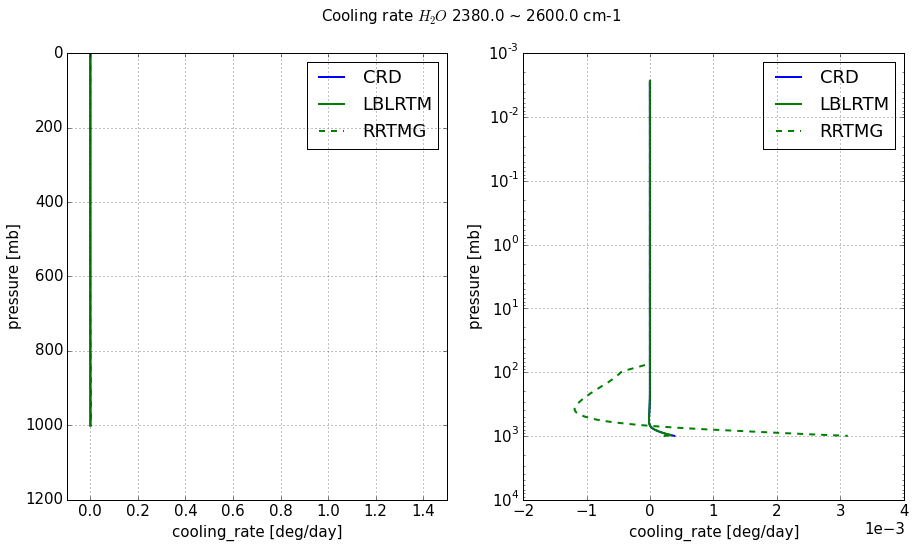

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.367763   0.000000 -0.367763      0.000000
30   299.800000 -0.367997   0.000020 -0.367977     -0.000034
0   1013.000000 -0.404431   0.076088 -0.328343      0.002536

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.366088   0.000000 -0.366088      0.000000
30   299.8000 -0.366327   0.000019 -0.366308     -0.000034
0   1013.0000 -0.403547   0.075430 -0.328116      0.002112

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.3668     0.0000   -0.3668      -0.00000
30   299.70000  -0.3679     0.0002   -0.3677      -0.00013
0   1013.00000  -0.4713     0.1516   -0.3197       0.00297

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.001675   0.000000 -0.001675  0.000000e+00
30  0.000000

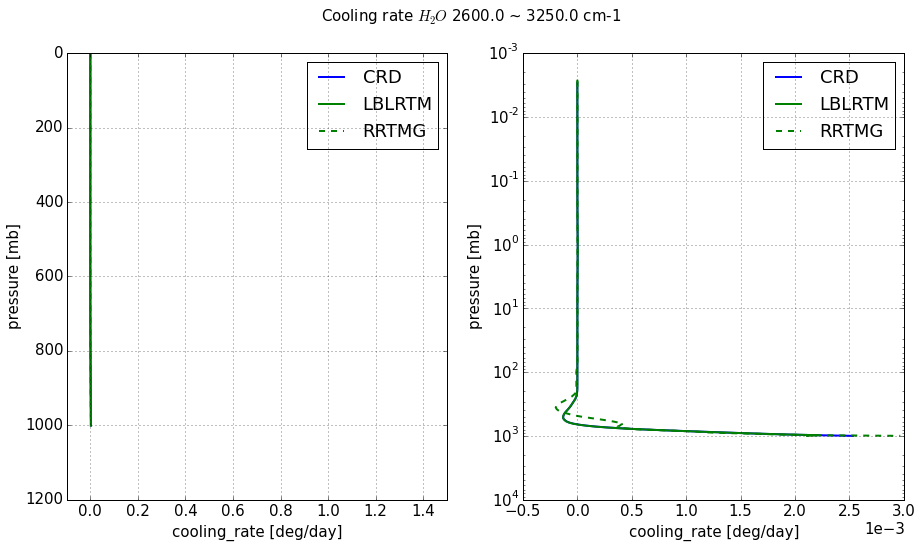

In [221]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd), \
                               ('LBLRTM', 'g', '-', pnl_lblrtm))   

# In CLIRAD's wavenumber bands

In [217]:


def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()
    wbands = list(range(1, 10 + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    
    lbl_pnls_by_clirad_bands = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
                              for pnl_lbl in pnls_lbl]
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in lbl_pnls_by_clirad_bands]
        dfs.append(pnl_clirad[wband].loc[atm_levels, :])
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in lbl_pnls_by_clirad_bands]
        dfs.append(pnl_clirad[wband])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = True,\
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and cooling rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 0 ~ 340 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.310935   0.000000 -34.310935      0.000000
30   299.800000 -36.441826  21.391389 -15.050438      1.376942
0   1013.000000 -51.093040  51.071508  -0.021532      0.007733

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -34.414209   0.000000 -34.414209      0.000000
30   299.8000 -36.581592  21.327248 -15.254344      1.271039
0   1013.0000 -51.100657  51.173323   0.072666      0.029632

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.03330   0.001232 -34.032068      6.148719
30   299.800000 -36.40643  21.663380 -14.743050      1.350754
0   1013.000000 -51.09213  51.070570  -0.021560      0.007725

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_

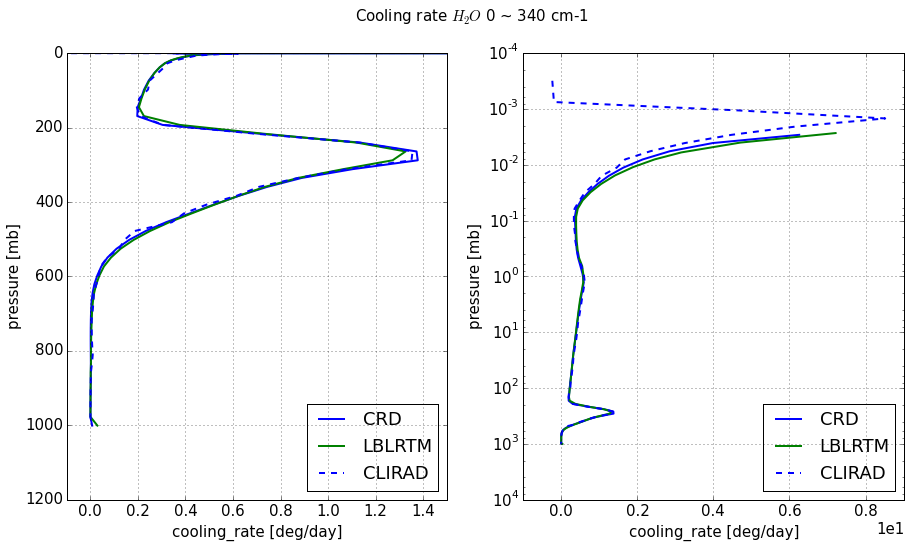

---------------------------------------------------------------------------


Wavenumber band: 2, 340 ~ 540 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.541409   0.000000 -60.541409      0.000000
30   299.800000 -61.600467   6.651864 -54.948602      0.644241
0   1013.000000 -82.315835  81.330012  -0.985823      0.130917

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.328425   0.000000 -60.328425      0.000000
30   299.8000 -61.423870   6.869068 -54.554802      0.627782
0   1013.0000 -82.315849  81.374680  -0.941169      0.139025

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -59.82235   0.000003 -59.822347     -0.097136
30   299.800000 -60.99290   6.915163 -54.077737      0.649110
0   1013.000000 -82.31579  81.543440  -0.772350      0.156217

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.212984   0.000000 -0.212984      0

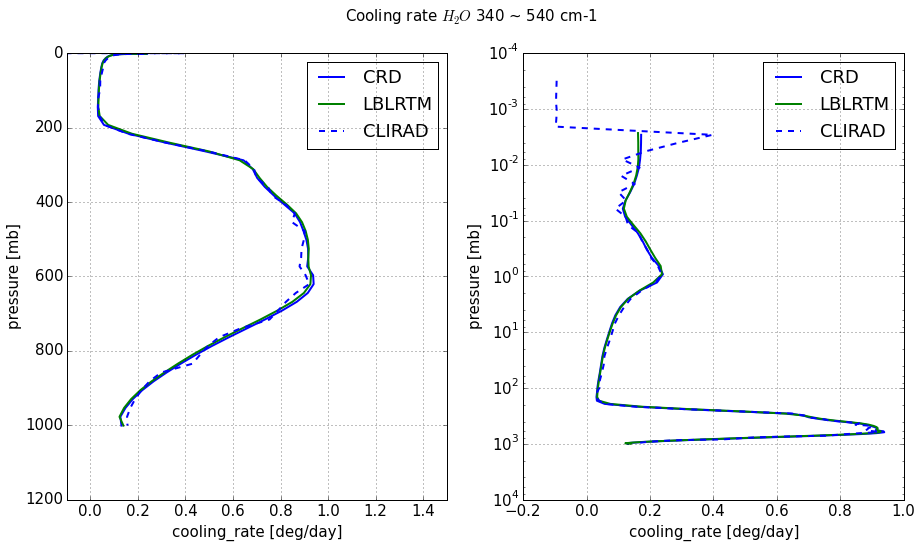

---------------------------------------------------------------------------


Wavenumber band: 3, 540 ~ 800 cm-1

CRD
       pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -99.015291   0.000000 -99.015291      0.000000
30   299.800000  -99.263422   0.874413 -98.389009      0.094366
0   1013.000000 -112.837813  71.524950 -41.312864      0.940123

LBLRTM
     pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.0024  -98.880869   0.000000 -98.880869      0.000000
30   299.8000  -99.137563   0.900061 -98.237502      0.093321
0   1013.0000 -112.816764  71.677675 -41.139088      0.915718

CLIRAD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -97.71744   0.000003 -97.717437     -0.000004
30   299.800000  -97.92890   0.674001 -97.254899      0.089588
0   1013.000000 -112.81600  73.117410 -39.698590      0.909037

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.134422   0.000000 -0.1

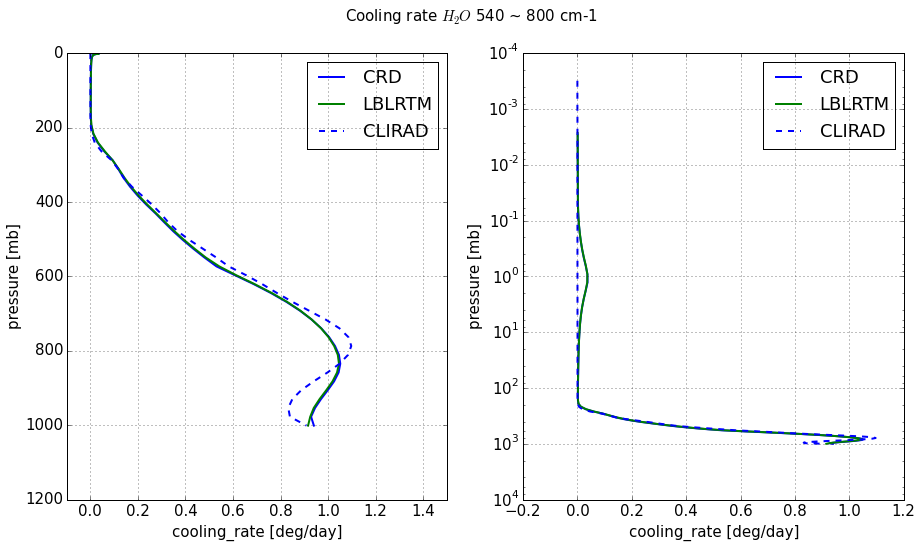

---------------------------------------------------------------------------


Wavenumber band: 4, 800 ~ 980 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.486170   0.000000 -60.486170      0.000000
30   299.800000 -60.493092   0.006507 -60.486585      0.000067
0   1013.000000 -61.681243   7.708875 -53.972367      0.222374

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.454948   0.000000 -60.454948      0.000000
30   299.8000 -60.461849   0.006193 -60.455657      0.000022
0   1013.0000 -61.657526   7.643344 -54.014182      0.210667

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -60.32822  6.214958e-10 -60.328220     -0.000000
30   299.800000 -60.33170  2.764044e-03 -60.328936     -0.000079
0   1013.000000 -61.64931  8.491215e+00 -53.158095      0.242118

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.031222   0.000000 -0.0

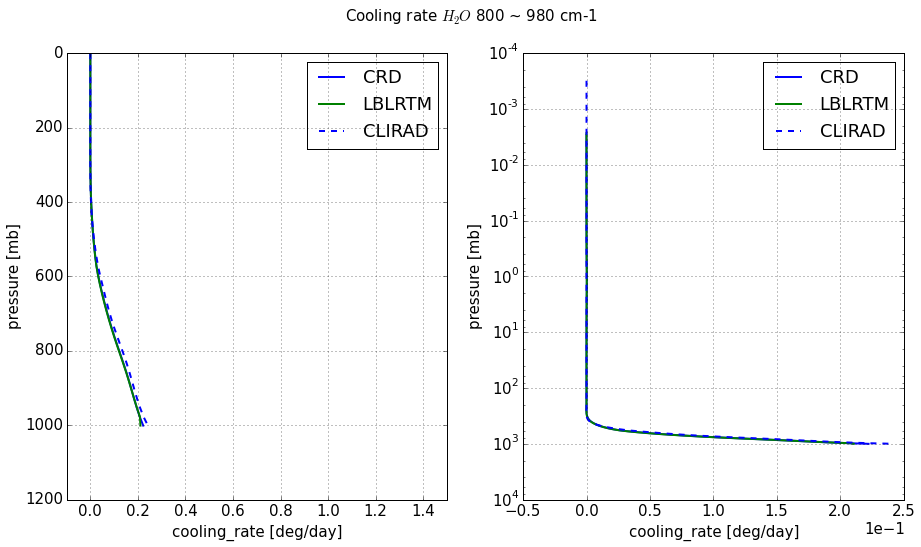

---------------------------------------------------------------------------


Wavenumber band: 5, 980 ~ 1100 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.905162   0.000000 -30.905162      0.000000
30   299.800000 -30.907243   0.001333 -30.905910     -0.000103
0   1013.000000 -31.354231   2.633614 -28.720617      0.085000

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.879242   0.000000 -30.879242      0.000000
30   299.8000 -30.881315   0.001280 -30.880035     -0.000105
0   1013.0000 -31.337711   2.634985 -28.702725      0.080500

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.84983  4.351434e-07 -30.849830     -0.000001
30   299.800000 -30.85086  5.959812e-04 -30.850264     -0.000072
0   1013.000000 -31.34389  3.026181e+00 -28.317709      0.096365

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.025920   0.000000 -0.

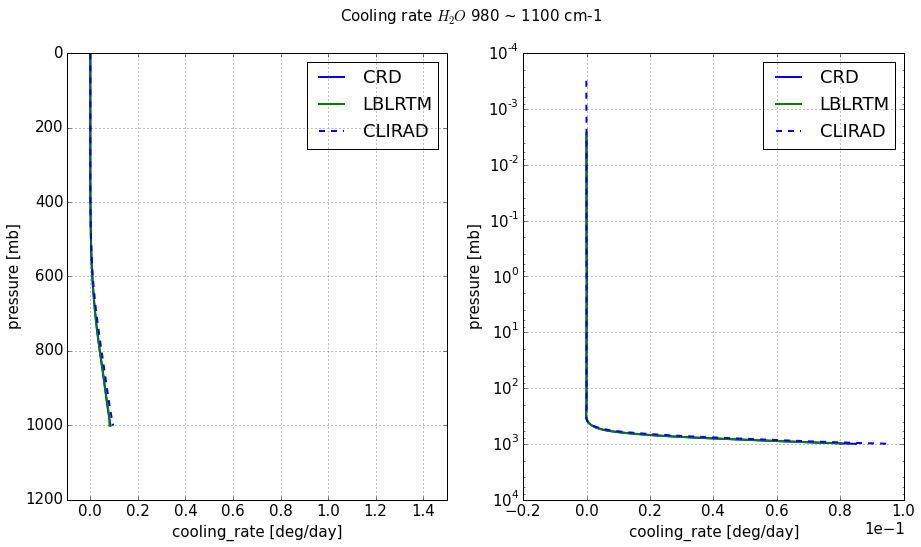

---------------------------------------------------------------------------


Wavenumber band: 6, 1100 ~ 1215 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.773071   0.000000 -21.773071      0.000000
30   299.800000 -21.785504   0.012772 -21.772732      0.000306
0   1013.000000 -23.269652   6.305412 -16.964240      0.160466

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -21.757789   0.000000 -21.757789      0.000000
30   299.8000 -21.770345   0.012577 -21.757768      0.000266
0   1013.0000 -23.254791   6.298861 -16.955930      0.156404

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -21.79535  2.657388e-13 -21.795350 -3.024772e-09
30   299.800000 -21.80484  8.713370e-03 -21.796127  9.956238e-05
0   1013.000000 -23.27341  6.326471e+00 -16.946939  1.579750e-01

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.015281   0.000000 -0

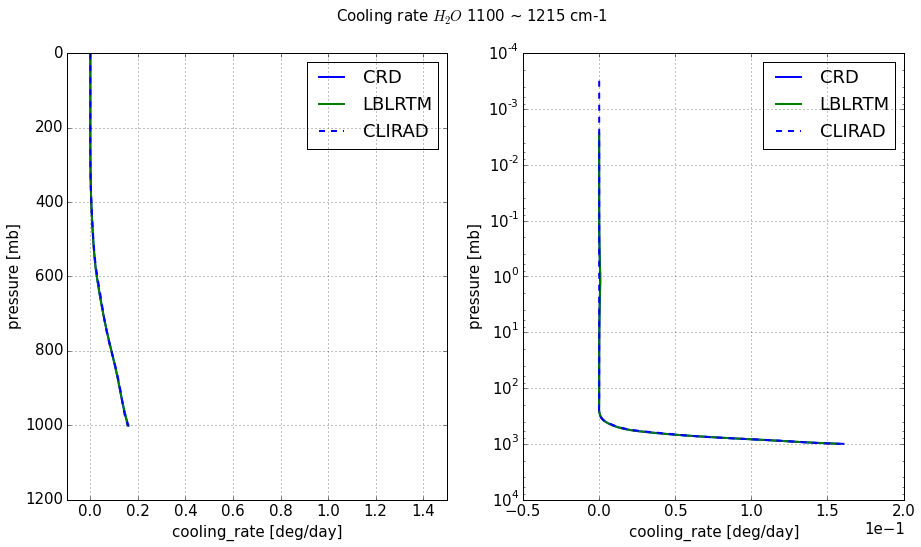

---------------------------------------------------------------------------


Wavenumber band: 7, 1215 ~ 1380 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -16.067263   0.000000 -16.067263      0.000000
30   299.800000 -16.197831   0.207324 -15.990508      0.012007
0   1013.000000 -23.755165  18.572777  -5.182388      0.187100

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -16.086567   0.000000 -16.086567      0.000000
30   299.8000 -16.218299   0.207811 -16.010487      0.011503
0   1013.0000 -23.736876  18.476167  -5.260709      0.187584

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -16.32561  4.906120e-10 -16.325610 -6.565916e-07
30   299.800000 -16.46534  2.195141e-01 -16.245826  1.407870e-02
0   1013.000000 -23.74060  1.784015e+01  -5.900450  2.084762e-01

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.019304   0.000000  0

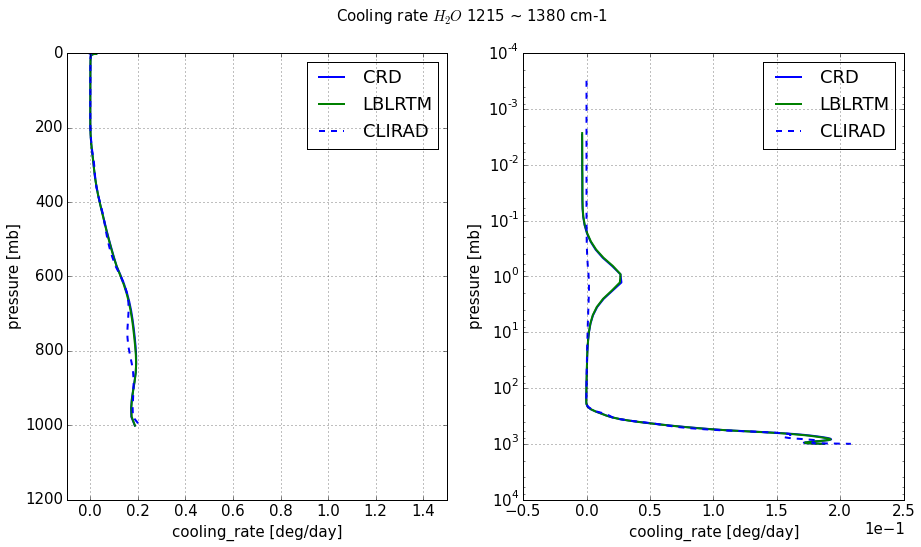

---------------------------------------------------------------------------


Wavenumber band: 8, 1380 ~ 1900 cm-1

CRD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.265696   0.000000 -7.265696      0.000000
30   299.800000  -8.191717   1.754197 -6.437520      0.102059
0   1013.000000 -30.729595  30.640991 -0.088604      0.027174

LBLRTM
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -7.304761   0.000000 -7.304761      0.000000
30   299.8000  -8.246787   1.767938 -6.478849      0.094475
0   1013.0000 -30.697533  30.596919 -0.100614      0.019163

CLIRAD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.341434   0.000002 -7.341432     -0.165602
30   299.800000  -8.295568   1.769966 -6.525602      0.097178
0   1013.000000 -30.880560  30.708790 -0.171770      0.059902

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.039066   0.000000  0.039066      0.00000

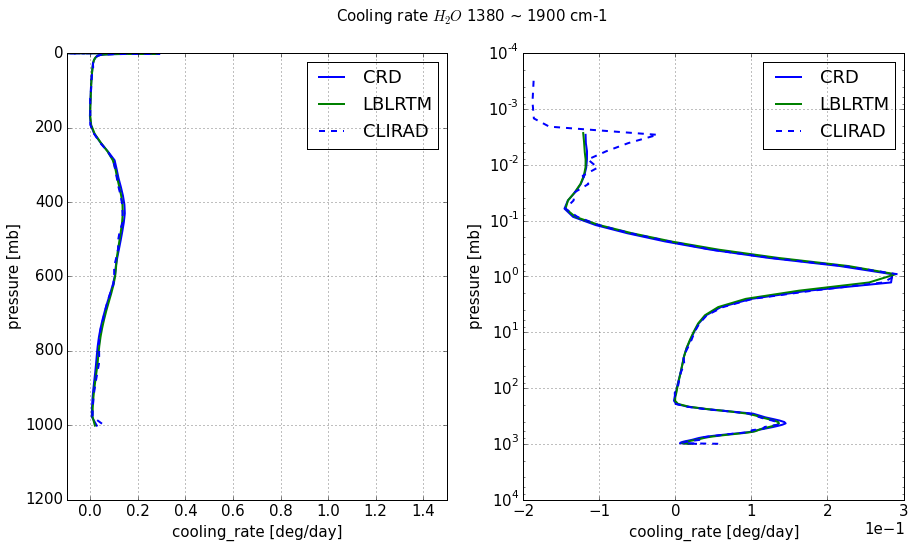

---------------------------------------------------------------------------


Wavenumber band: 9, 1900 ~ 3000 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -5.120375   0.000000 -5.120375      0.000000
30   299.800000 -5.134693   0.013024 -5.121669     -0.000221
0   1013.000000 -6.625445   3.073782 -3.551663      0.050266

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.069402   0.000000 -5.069402      0.000000
30   299.8000 -5.083684   0.013152 -5.070533     -0.000185
0   1013.0000 -6.614782   3.026062 -3.588721      0.027784

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -4.861082   0.000000 -4.861082     -0.000000
30   299.800000 -4.875098   0.012047 -4.863051     -0.000178
0   1013.000000 -6.674498   3.427002 -3.247496      0.060868

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.050973   0.000000 -0.050973      0.000000
30  0.0000

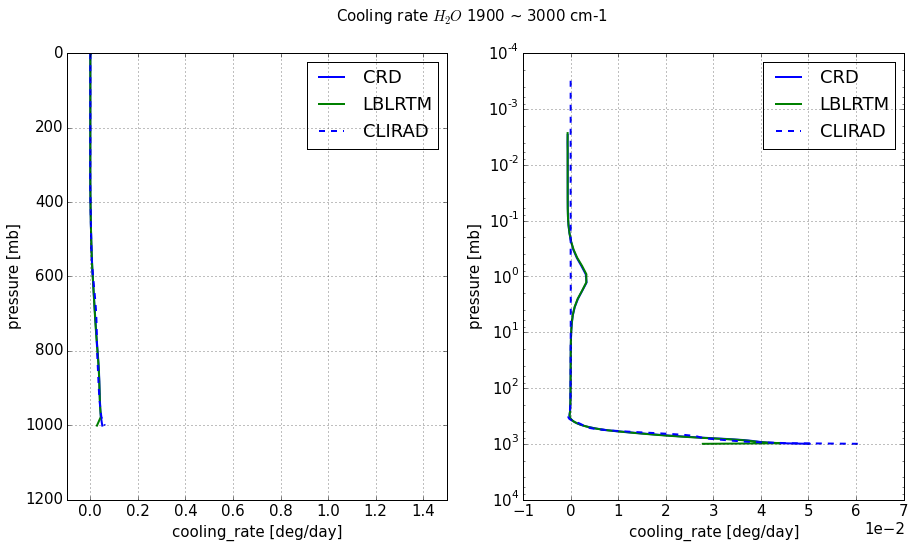

---------------------------------------------------------------------------


Wavenumber band: 10, 540 ~ 620 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -29.563330   0.000000 -29.563330      0.000000
30   299.800000 -29.715745   0.607149 -29.108595      0.064925
0   1013.000000 -36.235420  32.287543  -3.947877      0.266056

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -29.456983   0.000000 -29.456983      0.000000
30   299.8000 -29.616186   0.631945 -28.984241      0.064959
0   1013.0000 -36.231410  32.412175  -3.819235      0.256118

CLIRAD
       pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.002417       -0          0         0            -0
30   299.800000       -0          0         0            -0
0   1013.000000       -0          0         0            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.106347   0.000000 -0.106347      0.000000

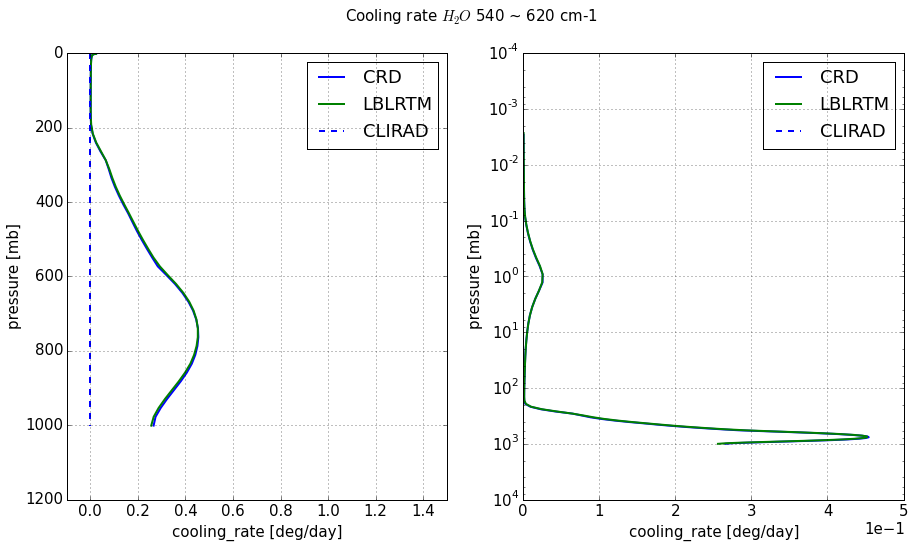

In [222]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd), \
                                ('LBLRTM', 'g', '-', pnl_lblrtm))

In [219]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')